In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import re

In [2]:
F_NAME = 'bandit-data.txt'

with open(F_NAME) as f:
  raw_lines = [line for line in f.readlines()]

In [3]:
print len(raw_lines)
print raw_lines[:10]

34190
['action-selection-(Random)-0: 39837.0\n', 'action-selection-(Random)-1: 39971.0\n', 'action-selection-(Random)-2: 39738.0\n', 'action-selection-(Random)-3: 39993.0\n', 'action-selection-(Random)-4: 39905.0\n', 'action-selection-(Random)-5: 40225.0\n', 'action-selection-(Random)-6: 40381.0\n', 'action-selection-(Random)-7: 40188.0\n', 'action-selection-(Random)-8: 39824.0\n', 'action-selection-(Random)-9: 39938.0\n']


In [4]:
# Parse all key value paris with the partten: <key>: <value>\n
key_value_prog = re.compile(r"^(.*): ([-\d\.]*)\n$")

kvs = {}
for line in raw_lines:
    m = key_value_prog.match(line)
    if m is None:
        raise RuntimeError("The following line is incorrect:\n" + line)
        
    kvs[m.group(1)] = float(m.group(2))

In [5]:
num_problems = kvs.pop('total-problems')
print "Number of problems ", num_problems
num_steps = kvs.pop('total-steps')
print "Number of steps ", num_steps
num_arms = int(kvs.pop('num-arms'))
print "Number of arms ", num_arms

Number of problems  2000.0
Number of steps  1000.0
Number of arms  10


In [6]:
# Parse total rewards with the partten: total-reward-(<policy_name>)
total_reward_prog = re.compile(r"^total-reward-\((.*)\)$")
kvs_keys = sorted(kvs.keys())

policy_names = []

for key in kvs_keys:
    m = total_reward_prog.match(key)
    if m is not None:
        average_reward = kvs.pop(key) / num_problems
        policy_name = m.group(1)
        policy_names.append(policy_name)
        print "Average rewards for %s: %s" % (policy_name, average_reward)

Average rewards for Random: -0.00672289567234
Average rewards for eps-0.05: 1.31828276226
Average rewards for eps-0.05-5: 1.37183661479
Average rewards for eps-0.05-5-s: 1.3566460488
Average rewards for eps-0.1: 1.28901752394
Average rewards for eps-0.1-5: 1.31453420424
Average rewards for eps-0.1-5-s: 1.28605863791
Average rewards for ucb: 1.3819902272
Average rewards for ucb-0.5: 1.47243914271
Average rewards for ucb-0.8: 1.48079523754
Average rewards for ucb-1: 1.47354356506
Average rewards for ucb-1.414: 1.44130409033
Average rewards for ucb-s: 1.2045453838
Average rewards for ucb-s-0.5: 1.41247979992
Average rewards for ucb-s-0.8: 1.36970346681
Average rewards for ucb-s-1: 1.33990856737
Average rewards for ucb-s-1.414: 1.28435888169


In [7]:
# Parse the square error and best action selection for each step.
square_error_prog = re.compile(r"^square-error-\((.*)\)-(.*)$")
best_action_prog = re.compile(r"^best-action-\((.*)\)-(.*)$")
action_selection_prog = re.compile(r"^action-selection-\((.*)\)-(.*)$")

square_errors = {}
best_action = {}
action_selection = {}
for policy_name in policy_names:
    square_errors[policy_name] = [np.nan] * int(num_steps)
    best_action[policy_name] = [-1] * int(num_steps)
    action_selection[policy_name] = [-1] * num_arms 
    
for key, value in kvs.items():
    m = square_error_prog.match(key)
    if m is not None:
        policy_name = m.group(1)
        step_index = int(m.group(2))
        average_square_error = value / num_problems
        square_errors[policy_name][step_index] = average_square_error
        continue
        
    m = best_action_prog.match(key)  
    if m is not None:
        policy_name = m.group(1)
        step_index = int(m.group(2))
        best_action_selection_ratio = value / num_problems
        best_action[policy_name][step_index] = best_action_selection_ratio 
        continue
        
    m = action_selection_prog.match(key)  
    if m is not None:
        policy_name = m.group(1)
        action_ranking = int(m.group(2))
        count = value / num_problems
        action_selection[policy_name][action_ranking] = count 
        continue
    
    raise ValueError("Key %s cannot be parsed." % key)
    
    
    

In [8]:
print "All policies: ", policy_names
plot_policies = ['Random', 'eps-0.05-5', 'eps-0.1-5', 'ucb-0.8', 'ucb-s-0.8']
print "Plotted policies: ", plot_policies

All policies:  ['Random', 'eps-0.05', 'eps-0.05-5', 'eps-0.05-5-s', 'eps-0.1', 'eps-0.1-5', 'eps-0.1-5-s', 'ucb', 'ucb-0.5', 'ucb-0.8', 'ucb-1', 'ucb-1.414', 'ucb-s', 'ucb-s-0.5', 'ucb-s-0.8', 'ucb-s-1', 'ucb-s-1.414']
Plotted policies:  ['Random', 'eps-0.05-5', 'eps-0.1-5', 'ucb-0.8', 'ucb-s-0.8']


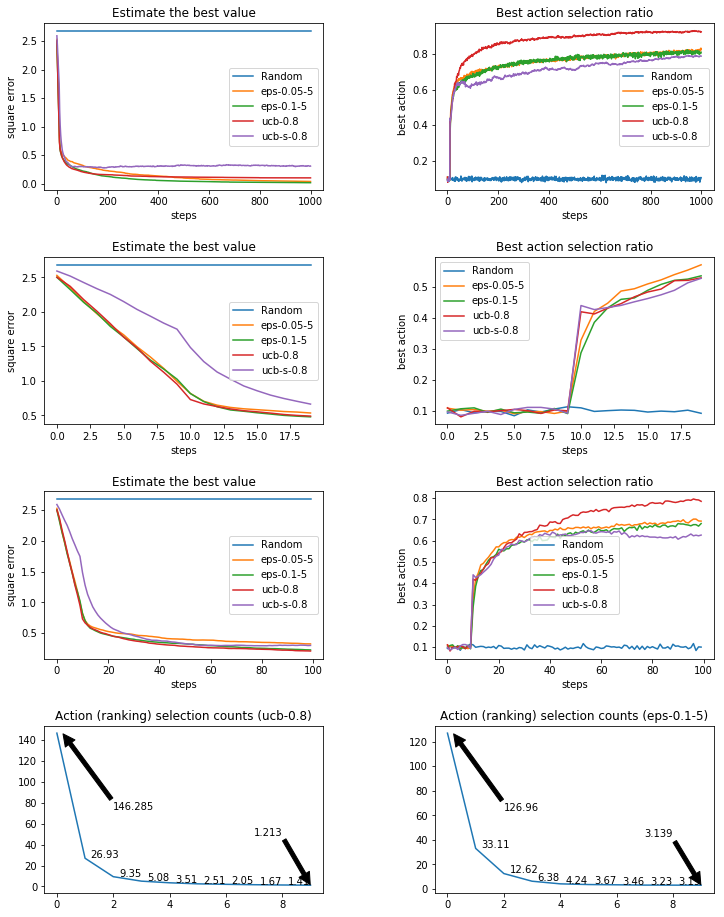

In [9]:
fig = plt.figure(figsize=(12, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

def plot_square_errors(steps_interested):
    time_steps = np.linspace(0, steps_interested * 1.0 - 1, steps_interested)
    
    lines = []
    for policy_name in plot_policies:
        line, = plt.plot(time_steps, square_errors[policy_name][:steps_interested],
                         label=policy_name)
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('steps')
    plt.ylabel('square error')
    plt.title('Estimate the best value')
    
def plot_best_action(steps_interested):
    time_steps = np.linspace(0, steps_interested * 1.0 - 1, steps_interested)

    lines = []
    for policy_name in plot_policies:
        line, = plt.plot(time_steps, best_action[policy_name][:steps_interested], 
                         label=policy_name)
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('steps')
    plt.ylabel('best action')
    plt.title('Best action selection ratio')
    
def plot_histgram_of_action_selection(policy_interested, ax):
    plt.plot(action_selection[policy_interested])  
    max_value = action_selection[policy_interested][0]
    min_value = action_selection[policy_interested][num_arms - 1]
    ax.annotate(('%s' % max_value),
                xy=(0.2, max_value),
                xytext=(2, max_value / 2),
                arrowprops=dict(facecolor='black', shrink=0.01),
               )
    ax.annotate(('%s' % min_value),
                xy=(num_arms - 1, min_value),
                xytext=(num_arms - 3, max_value / 3),
                arrowprops=dict(facecolor='black', shrink=0.01),
               )
    
    # Other points
    for index in range(num_arms - 2):
        x = index + 1
        y = action_selection[policy_interested][x]
        ax.annotate("{0:.2f}".format(y), xy=(x + 0.2, y + 0.2))
    plt.title('Action (ranking) selection counts (%s)' % policy_interested)

plt.subplot(4, 2, 1)
plot_square_errors(steps_interested=int(num_steps))

plt.subplot(4, 2, 2)
plot_best_action(steps_interested=int(num_steps))

# Plot first 20 steps
steps_interested = 20

plt.subplot(4, 2, 3)
plot_square_errors(steps_interested=steps_interested)

plt.subplot(4, 2, 4)
plot_best_action(steps_interested=steps_interested)

# Plot first 100 steps
steps_interested = 100

plt.subplot(4, 2, 5)
plot_square_errors(steps_interested=steps_interested)

plt.subplot(4, 2, 6)
plot_best_action(steps_interested=steps_interested)

ax = plt.subplot(4, 2, 7)
plot_histgram_of_action_selection(policy_interested='ucb-0.8', ax=ax)

ax = plt.subplot(4, 2, 8)
plot_histgram_of_action_selection(policy_interested='eps-0.1-5', ax=ax)

plt.show()